In [29]:
import requests
from bs4 import BeautifulSoup
import requests
from paperview.retrieval.biorxiv_api import (
    query_content_detail_by_doi, 
    query_content_detail_by_interval,
    get_all_content_details_by_interval,
    query_article_by_doi,
    ArticleDetail,
    Article
)
from paperview.retrieval.biorxiv_web import (
    get_content_detail_for_page,
    NamedTemporaryPDF
    )

from pikepdf import Pdf, PdfImage
from io import StringIO

from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfdocument import PDFDocument
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.pdfpage import PDFPage
from pdfminer.pdfparser import PDFParser
from io import StringIO
from pdfminer.high_level import extract_text_to_fp
from pdfminer.layout import LAParams


%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
url = 'https://www.biorxiv.org/content/10.1101/2022.07.21.500746v1'
content_detail = get_content_detail_for_page(url=url)

In [30]:
article = Article.from_content_page_url(url)

In [31]:
article


Article(
    title='Evaluating instruments for assessing healthspan: a multi-center cross-sectional study on health-related quality of life (HRQL) and frailty in the companion dog',
    authors=['Chen, F. L.', 'Ullal, T. V.', 'Graves, J. L.', 'Ratcliff, E. R.', 'Naka, A.', 'McKenzie, B.', 'Carttar, T. A.', 'Super, K. M.', 'Austriaco, J.', 'Weber, S. Y.', 'LaCroix-Fralish, M. L.', 'Vaughn, J.'],
    date='2022-07-22',
    category='physiology',
    doi='10.1101/2022.07.21.500746',
    author_corresponding='Frances L. Chen',
    author_corresponding_institution='Cellular Longevity, Inc.',
    version='1',
    type='new results',
    license='cc_by_nc_nd',
    published='NA',
    server='biorxiv')

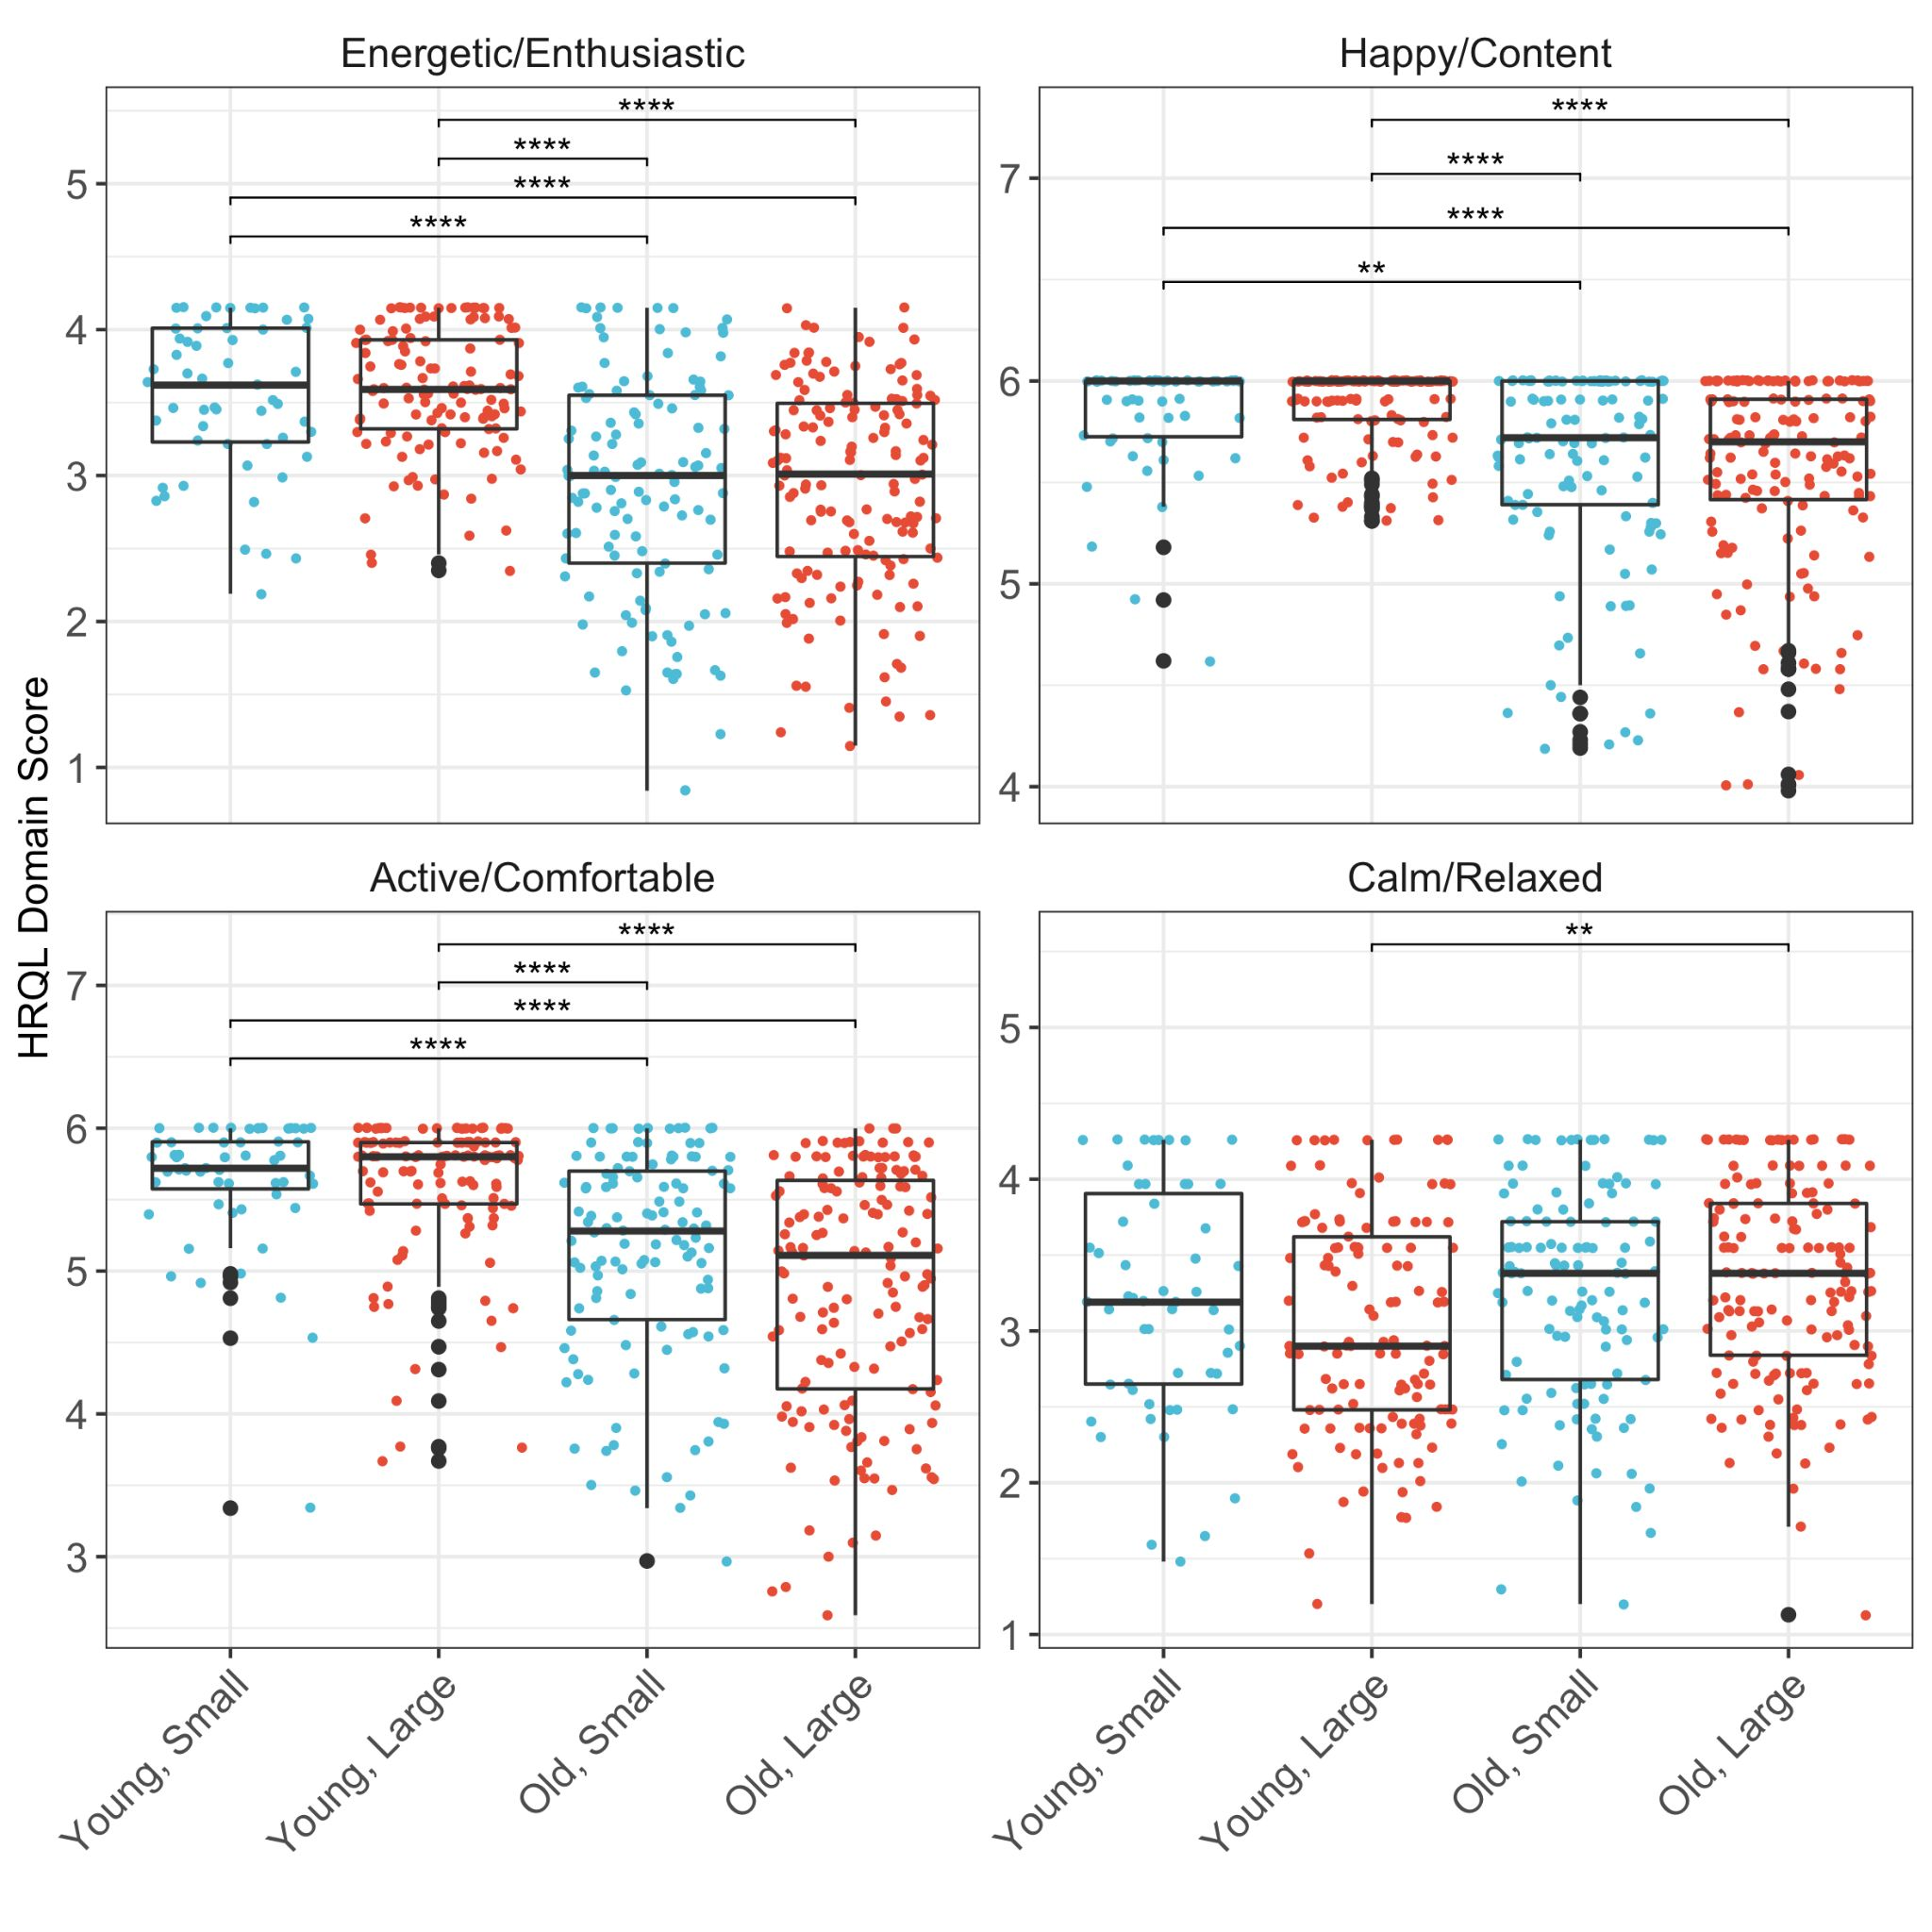

In [33]:
article.images[4]['image']

In [ ]:

article.display_html()